In [9]:
import MPPIController
import numpy as np
import time
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

# Block on a slope

Try MPPI controller with a simple block on a slope.

*TODO*: add optional friction on the slope

In [41]:
class BlockOnSlope:
    # Apply a force parallel to the slope to achieve a desired position
    # and velocity of the block
    
    def __init__(self, initial_state, block_mass, slope_angle, g, dt, mu_k=0):
        self.initial_state = initial_state
        self.block_mass = block_mass
        self.slope_angle = slope_angle
        self.g = g
        self.desired_state = None
        self.dt = dt
        self.mu_k = mu_k
        self.nx, self.nu = (2, 1)
        
        self.controller = MPPIController.MPPIController(
            n_rollouts=200,
            horizon_length=10,
            exploration_cov=np.array([[10 ** 2]]),
            exploration_lambda=5,
            nx=self.nx,
            nu=self.nu,
            terminal_cost=self.terminal_cost,
            state_cost=self.state_cost,
            control_cost=self.control_cost,
            evolve_state=self.evolve_state,
            control_cov=np.array([[1]]),
            dt=dt
        )
    
    def set_desired_state(self, desired_state):
        self.desired_state = desired_state

    def terminal_cost(self, x):
        error = (self.desired_state - x)
        Q = np.array([[3, 0], [0, 1]])
        
        return error.T @ Q @ error

    def state_cost(self, x):
        error = (desired_state - x)
        Q = np.array([[1, 0], [0, 1]])
        
        return error.T @ Q @ error

    def control_cost(self, u, noise):
        noisy_control = u + noise
        R = np.diag([0.5 * 1e-2])

        return noisy_control.T @ R @ noisy_control

    def evolve_state(self, x, u, dt):
        pos, vel = x

        accel = (self.g * np.sin(self.slope_angle)) + (u[0] / self.block_mass)

        evolved_state = np.array([
            pos + vel * dt + 0.5 * accel * (dt ** 2),
            vel + accel * dt
        ])

        return evolved_state

    def simulator(self, x, u):
        return self.evolve_state(x, u, dt=dt)

In [42]:
dt = 1 / 10
desired_state = np.array([10, 0])

block_env = BlockOnSlope(
    initial_state=np.array([0, 0])
    block_mass = 5, # kg
    slope_angle = np.radians(30), # radians
    g = -9.81, # m / s^2
    dt = dt # s
)

block_env.set_desired_state(np.array([10, 0]))

[MPPI] [Warn] No control range input. Assuming [-inf, inf] on all dimensions.


In [43]:
# Create the control loop to run MPPI

simulation_length = 10  # seconds

# Create some lists to hold plotted information
control_seq = []
xs = []

n_steps = int((1 / dt) * simulation_length)

for _ in range(0, n_steps):
    action = block_env.controller.step(current_state)
    control_seq.append(next_u[0])

    current_state = block_env.simulator(current_state, action)
    xs.append(current_state[0])

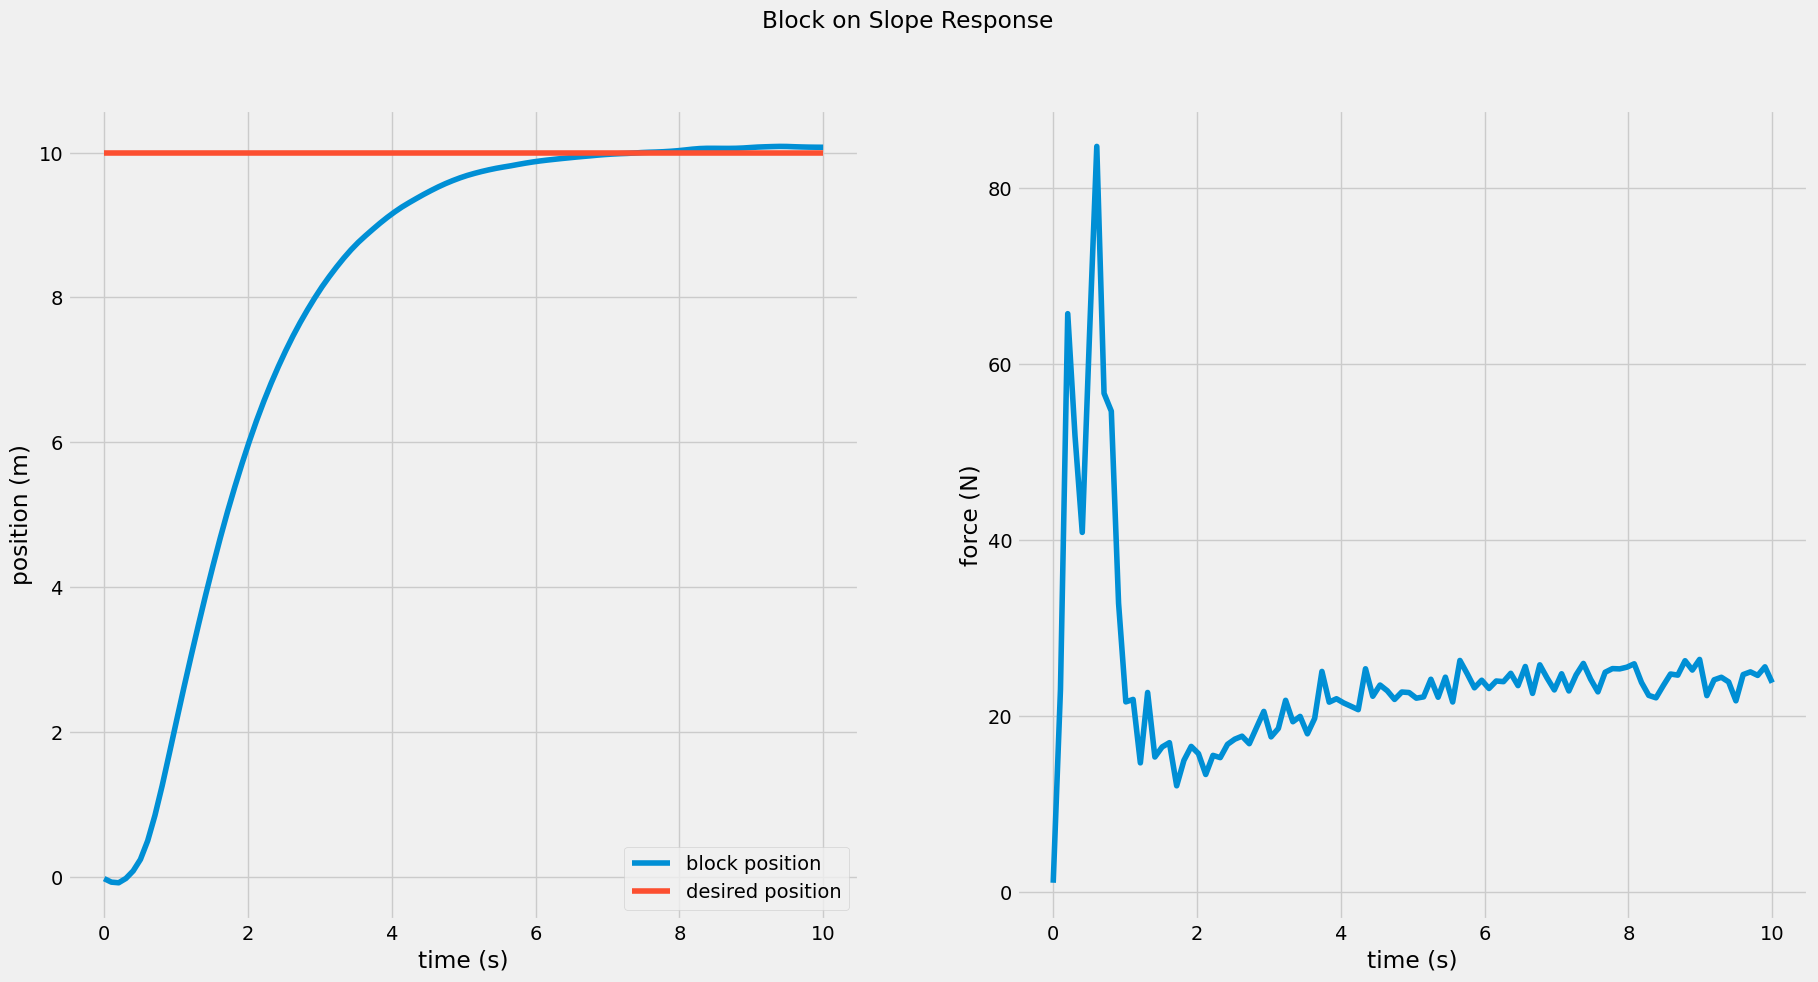

In [44]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Block on Slope Response")

time = np.linspace(0, simulation_length, n_steps)

ax1.plot(time, xs, label="block position")
ax1.plot(time, np.repeat(desired_state[0], n_steps), label="desired position")
ax1.set(xlabel="time (s)", ylabel="position (m)")
ax1.legend()

ax2.plot(time, control_seq, label="control")
ax2.set(xlabel="time (s)", ylabel="force (N)")

plt.show()

# Inverted pendulum
Try MPPI controller with an inverted pendulum using `gym` environments

In [1]:
import gymnasium as gym

In [50]:
class InvertedPendulum:
    def __init__(self, initial_state, g, dt):
        self.desired_state = None
        self.g = -9.81
        self.m = 1
        self.l = 1
        self.dt = 0.05
        self.nx, self.nu = (2, 1)
        
        self.max_torque, self.max_speed = 2, 8
    
    def set_desired_state(self, desired_state):
        self.desired_state = desired_state
            
    def terminal_cost(self, x):
        error = (desired_state - x)
        Q = np.array([[3, 0], [0, 1]])
        
        return error.T @ Q @ error

    def state_cost(self, x):
        error = (desired_state - x)
        Q = np.array([[1, 0], [0, 1]])
        
        return error.T @ Q @ error

    def control_cost(self, u, noise):
        noisy_control = u + noise
        R = np.diag([0.5 * 1e-2])

        return noisy_control.T @ R @ noisy_control

    def evolve_state(self, x, u, dt):
        th, thdot = x

        u = np.clip(u, -self.max_torque, self.max_torque)[0]
        newthdot = thdot + (3 * self.g / (2 * self.l) * np.sin(th) + 3.0 / (self.m * self.l**2) * u) * self.dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        
        newth = th + newthdot * dt

        return np.array([newth, newthdot])
    
    def simulator(self, x, u):
        return self.evolve_state(x, u, dt=dt)

In [45]:
for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    
    state_space_observation = transform_observation(observation)
    print(observation)
    
    if terminated or truncated:
        observation, info = env.reset()

print(observation, info)

TypeError: transform_observation() missing 1 required positional argument: 'obs'